In [11]:
import pandas as pd
import easyocr 
import sys
sys.path.append('C:/IDE/repository/liquid_vapor_database')
from src.table_gridlines import Gridlines
from src.pdf_image_extractor import PDFImageExtractor

PAGE_NUM = 134



img_path = f'C:/IDE/repository/liquid_vapor_database/pdf_data/page_{PAGE_NUM}/page_{PAGE_NUM}_processed.png'

reader = easyocr.Reader(['ru', 'en'])
result = reader.readtext(img_path)
easyocr_df = pd.DataFrame(result, columns=['bbox','text','conf'])
detector = Gridlines(img_path, easyocr_df, debug=True)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


FileNotFoundError: No such file: 'C:\IDE\repository\liquid_vapor_database\pdf_data\page_156\page_156_processed.png'

<Axes: >

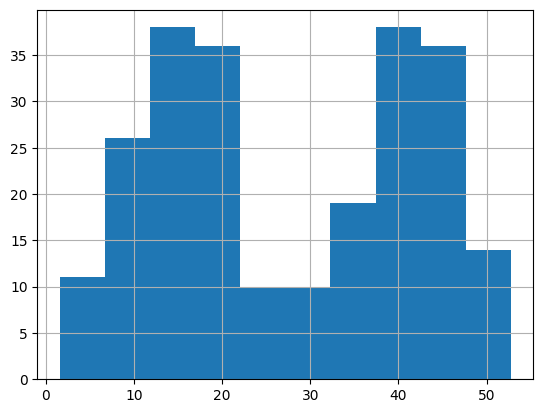

In [10]:
easyocr_df['bbox_scale_position_x'] = easyocr_df['bbox'].apply(lambda x: ((x[0][0] + x[1][0]) / 2) / 25)
easyocr_df['bbox_scale_position_y'] = easyocr_df['bbox'].apply(lambda y: ((y[0][1] + y[2][1]) / 2) / 50)

easyocr_df['bbox_scale_position_y'].hist()


In [8]:
# Extracting all x and y coordinates from bbox
x_coords = [x for bbox in easyocr_df['bbox'] for x, _ in bbox]
y_coords = [y for bbox in easyocr_df['bbox'] for _, y in bbox]

# Finding the min and max of x and y coordinates
min_x, max_x = min(x_coords), max(x_coords)
min_y, max_y = min(y_coords), max(y_coords)

min_x, max_x, min_y, max_y

(52, 1668, 54, 2658)

In [18]:
import numpy as np
import cv2
import re

img = cv2.imread(img_path)

# Определение размеров и создание пустого изображения для наложения
overlay = np.zeros_like(img)

def is_number(s):
    s = s.replace('_', '')  # Удалить нижние подчеркивания, если они есть
    try:
        float(s)  # для чисел с плавающей точкой
        return True
    except ValueError:
        return False

# Определить размеры изображения и разделить на _ частей по вертикали
height, width, _ = img.shape
section_height = height // 15

# Сортировать области по верхней координате Y
easyocr_df['top_y'] = easyocr_df['bbox'].apply(lambda x: x[0][1])  # Принимаем Y верхнего левого угла
easyocr_df = easyocr_df.sort_values(by='top_y')

# Статистика по секциям
section_density = []

# Инициализация счетчиков для каждой секции
for i in range(15):
    section_density.append({'text_count': 0, 'number_count': 0, 'min_y': i * section_height, 'max_y': (i+1) * section_height})

# Подсчет областей в каждой секции
for index, row in easyocr_df.iterrows():
    bbox = row['bbox']
    top_y = bbox[0][1]
    section_index = int(top_y // section_height)  # Приведение к int

    if section_index < 15:  # Защита от выхода за пределы списка
        if is_number(row['text']):
            section_density[section_index]['number_count'] += 1
        else:
            section_density[section_index]['text_count'] += 1

# Определение принадлежности секции и отрисовка прозрачных прямоугольников
alpha = 0.4  # Прозрачность прямоугольников
for i, section in enumerate(section_density):
    if section['text_count'] > section['number_count']:
        color = (0, 255, 255)  # Желтый для текста
    else:
        color = (255, 0, 0)  # Синий для чисел

    # Рисование прямоугольника на пустом изображении
    cv2.rectangle(overlay, (0, section['min_y']), (width, section['max_y']), color, -1)

# Определение горизонтальных линий имен столбцов
column_lines = detector.detect_column_names_area()  # [(x1, y1, x2, y2), ...]

# Смещение границы желтой области к линии в синей области
for line in column_lines:
    _, y, _, _ = line  # координаты Y линии

    # Определение, в какой секции находится линия
    for i, section in enumerate(section_density):
        if section['min_y'] <= y <= section['max_y']:
            # Если линия в синей области
            if section_density[i]['number_count'] > section_density[i]['text_count']:
                # Поиск ближайшей желтой области выше
                for j in range(i - 1, -1, -1):
                    if section_density[j]['text_count'] > section_density[j]['number_count']:
                        # Смещение границы желтой области к линии
                        section_density[j]['max_y'] = y
                        break

# Рисование обновленных прямоугольников на изображении
for section in section_density:
    if section['text_count'] > section['number_count']:
        color = (0, 255, 255)  # Желтый для текста
    else:
        color = (255, 0, 0)  # Синий для чисел

    cv2.rectangle(overlay, (0, section['min_y']), (img.shape[1], section['max_y']), color, -1)

# Наложение прозрачных прямоугольников
alpha = 0.4
cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

# Сохранить изображение
cv2.imwrite(img_path.replace('.png', '_adjusted_sections.png'), img)

True

In [15]:
import numpy as np
import cv2
import re

# Функция для проверки, является ли строка числом
def is_number(s):
    s = s.replace('_', '')
    try:
        float(s)
        return True
    except ValueError:
        return False

# Функция для сортировки секций
def sort_sections(df):
    df['top_y'] = df['bbox'].apply(lambda x: x[0][1])
    return df.sort_values(by='top_y')

# Функция для расчета плотности секций
def calculate_section_density(df, img_shape, section_height):
    section_density = []
    for i in range(15):
        section_density.append({'text_count': 0, 'number_count': 0, 'min_y': i * section_height, 'max_y': (i+1) * section_height})
    
    for index, row in df.iterrows():
        bbox = row['bbox']
        top_y = bbox[0][1]
        section_index = int(top_y // section_height)

        if section_index < 15:
            if is_number(row['text']):
                section_density[section_index]['number_count'] += 1
            else:
                section_density[section_index]['text_count'] += 1
    
    return section_density

# Функция для рисования прозрачных прямоугольников
def draw_overlay(img, section_density, alpha=0.4):
    overlay = np.zeros_like(img)
    yellow_coords = []  # Для координат желтых областей
    blue_coords = []  # Для координат синих областей

    for section in section_density:
        color = (0, 255, 255) if section['text_count'] > section['number_count'] else (255, 0, 0)
        coords = (0, section['min_y'], img.shape[1], section['max_y'])

        if section['text_count'] > section['number_count']:
            yellow_coords.append(coords)
        else:
            blue_coords.append(coords)

        cv2.rectangle(overlay, (coords[0], coords[1]), (coords[2], coords[3]), color, -1)

    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
    return img, yellow_coords, blue_coords

# Функция для смещения границы секций
def adjust_for_column_lines(section_density, column_lines):    
    for line in column_lines:
        _, y, _, _ = line  # координаты Y линии
        # Определение, в какой секции находится линия
        for i, section in enumerate(section_density):
            if section['min_y'] <= y <= section['max_y']:
                # Если линия в синей области
                if section_density[i]['number_count'] > section_density[i]['text_count']:
                    # Поиск ближайшей желтой области выше
                    for j in range(i - 1, -1, -1):
                        if section_density[j]['text_count'] > section_density[j]['number_count']:
                            # Смещение границы желтой области к линии
                            section_density[j]['max_y'] = y
                            break
    return section_density

def can_be_merged(rect1, rect2):
    # Разбиваем координаты
    _, y1_1, _, y2_1 = rect1
    _, y1_2, _, y2_2 = rect2

    # Проверяем, соприкасаются ли прямоугольники по вертикали или находится ли один внутри другого
    vertical_touch = y2_1 == y1_2  # Изменено условие для точного соприкосновения
    vertical_overlap = (y1_1 < y2_2 and y2_1 > y1_2) or (y1_2 < y2_1 and y2_2 > y1_1)

    return vertical_touch or vertical_overlap

def merge_rectangles(coords):
    coords.sort(key=lambda x: x[1])
    merged_coords = []
    i = 0
    while i < len(coords) - 1:
        current = coords[i]
        next_rect = coords[i + 1]

        # Проверяем, можно ли объединить текущий и следующий прямоугольники
        if can_be_merged(current, next_rect):
            # Объединяем
            merged_rect = (current[0], current[1], next_rect[2], next_rect[3])
            # Проверяем, можно ли объединить следующий прямоугольник после текущего объединения
            i += 2  # Переходим к проверке следующего прямоугольника после следующего
            while i < len(coords) and can_be_merged(merged_rect, coords[i]):
                merged_rect = (merged_rect[0], merged_rect[1], coords[i][2], coords[i][3])
                i += 1
            merged_coords.append(merged_rect)
        else:
            merged_coords.append(current)
            i += 1

    # Добавляем последний прямоугольник, если он не был объединен
    if i == len(coords) - 1:
        merged_coords.append(coords[-1])

    return merged_coords

# Основная функция
def process_image(img_path, easyocr_df):
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    section_height = height // 15

    easyocr_df = sort_sections(easyocr_df)  # Исходя из предположения, что easyocr_df уже определен
    section_density = calculate_section_density(easyocr_df, img.shape, section_height)
    column_lines = detector.detect_column_names_area()  # Необходимо определить detector
    section_density = adjust_for_column_lines(section_density, column_lines)
    img, yellow_coords, blue_coords = draw_overlay(img, section_density)

    cv2.imwrite(img_path.replace('.png', '_adjusted_sections.png'), img)

    return merge_rectangles(yellow_coords), merge_rectangles(blue_coords)

# Вызов основной функции
yellow_coords, blue_coords = process_image(img_path, easyocr_df)


In [7]:
def can_be_merged(rect1, rect2):
    # Разбиваем координаты
    _, y1_1, _, y2_1 = rect1
    _, y1_2, _, y2_2 = rect2

    # Проверяем, соприкасаются ли прямоугольники по вертикали или находится ли один внутри другого
    vertical_touch = y2_1 == y1_2  # Изменено условие для точного соприкосновения
    vertical_overlap = (y1_1 < y2_2 and y2_1 > y1_2) or (y1_2 < y2_1 and y2_2 > y1_1)

    return vertical_touch or vertical_overlap

def merge_rectangles(coords):
    coords.sort(key=lambda x: x[1])
    merged_coords = []
    i = 0
    while i < len(coords) - 1:
        current = coords[i]
        next_rect = coords[i + 1]

        # Проверяем, можно ли объединить текущий и следующий прямоугольники
        if can_be_merged(current, next_rect):
            # Объединяем
            merged_rect = (current[0], current[1], next_rect[2], next_rect[3])
            # Проверяем, можно ли объединить следующий прямоугольник после текущего объединения
            i += 2  # Переходим к проверке следующего прямоугольника после следующего
            while i < len(coords) and can_be_merged(merged_rect, coords[i]):
                merged_rect = (merged_rect[0], merged_rect[1], coords[i][2], coords[i][3])
                i += 1
            merged_coords.append(merged_rect)
        else:
            merged_coords.append(current)
            i += 1

    # Добавляем последний прямоугольник, если он не был объединен
    if i == len(coords) - 1:
        merged_coords.append(coords[-1])

    return merged_coords

merged_blue_coords = merge_rectangles(yellow_coords)
for rect in merged_blue_coords:
    print(rect)

(0, 0, 1740, 1440)
(0, 1862, 1740, 2128)


In [16]:
def crop_and_save_image(image_path, rectangles, save_dir):
    # Загрузка изображения
    img = cv2.imread(image_path)
    if img is None:
        print("Ошибка загрузки изображения. Проверьте путь к изображению.")
        return

    # Обрезка и сохранение каждого прямоугольника
    for i, (x1, y1, x2, y2) in enumerate(rectangles):
        # Обрезка изображения согласно координатам
        crop_img = img[y1:y2, x1:x2]

        # Сохранение обрезанного изображения
        save_path = f"{save_dir}/cropped_{i+1}.png"
        cv2.imwrite(save_path, crop_img)
        print(f"Сохранено: {save_path}")

save_dir = 'C:/IDE/repository/liquid_vapor_database/pdf_data/page_133'       
crop_and_save_image(img_path, blue_coords, save_dir)

Сохранено: C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/cropped_1.png
Сохранено: C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/cropped_2.png
Сохранено: C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/cropped_3.png


In [16]:
img_path

'C:/IDE/repository/liquid_vapor_database/pdf_data/page_170/page_170_processed.png'

In [10]:
import pandas as pd

# easyocr_df - предположим, что это ваш DataFrame с результатами OCR

# Пересчитать координаты для более простого доступа
easyocr_df['x_min'] = easyocr_df['bbox'].apply(lambda bbox: bbox[0][0])
easyocr_df['y_min'] = easyocr_df['bbox'].apply(lambda bbox: bbox[0][1])
easyocr_df['x_max'] = easyocr_df['bbox'].apply(lambda bbox: bbox[2][0])
easyocr_df['y_max'] = easyocr_df['bbox'].apply(lambda bbox: bbox[2][1])

# Сортировка по Y, затем по X координатам
sorted_df = easyocr_df.sort_values(by=['y_min', 'x_min'])

# Группировка текста по строкам с учетом допуска в Y координатах
grouped_lines = {}
line_threshold = 10  # допуск в пикселях для Y координаты, чтобы считать тексты одной строки

for _, row in sorted_df.iterrows():
    added = False
    for y in grouped_lines:
        if abs(y - row['y_min']) < line_threshold:
            grouped_lines[y].append((row['x_min'], row['text']))
            added = True
            break
            
    if not added:
        grouped_lines[row['y_min']] = [(row['x_min'], row['text'])]

# Формирование итогового текста с пробелами, соответствующими расстоянию между словами
output_text = []
for y in sorted(grouped_lines.keys()):
    texts = sorted(grouped_lines[y], key=lambda x: x[0])
    line_text = ""
    last_x_end = 0
    for x, text in texts:
        space_count = max((x - last_x_end) // 20 - len(text), 0)  # количество пробелов между словами
        line_text += ' ' * space_count + text
        last_x_end = x + len(text) * 20  # обновление последнего x конца с учетом добавленного текста
    output_text.append(line_text)

# Сохраняем строки в текстовый файл
with open("output_text.txt", "w", encoding="utf-8") as file:
    for line in output_text:
        file.write(line + "\n")


TypeError: can't multiply sequence by non-int of type 'float'

In [15]:
import cv2
import numpy as np

# Замените это путем к вашему изображению
image_path = 'C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/page_133_processed.png'

# Загрузите изображение
img = cv2.imread(image_path)

# Предполагается, что easyocr_df - это ваш DataFrame
for index, row in easyocr_df.iterrows():
    bbox = row['bbox']
    text = row['text']

    # Находим координаты для текста: левый верхний угол и нижний правый
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    br = (int(br[0]), int(br[1]))

    # Установите параметры для текста: шрифт, размер и т.д.
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (0, 0, 255) # красный цвет
    font_thickness = 1

    # Нанесите текст на изображение
    img = cv2.putText(img, text, tl, font, font_scale, font_color, font_thickness, cv2.LINE_AA)

# Сохранить результат в файл
cv2.imwrite('C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/page_133_processed_easyocr.png', img)

True

In [17]:
easyocr_df['text'].to_list()

['Ni',
 '1(',
 'ВОДОРОД_МЕТАН',
 '[258]',
 'H2CH4',
 '?',
 '9',
 't',
 'Р, ата',
 'T',
 'Р , ата',
 '2.4',
 '96.8',
 '-182.7',
 '49',
 '6.4',
 '-163.0',
 '78',
 '3.6',
 '97.5',
 '76',
 '7.7',
 '94.2',
 '90',
 '5.0',
 '96.9',
 '102',
 '8.5',
 '93.6',
 '97',
 '6.4',
 '139',
 '8.7',
 '91.9',
 '103',
 '8.1',
 '96.8',
 '164',
 '11.1',
 '91.2',
 '138',
 '8.2',
 '96.4',
 '171',
 '11.9',
 '92.0',
 '141',
 '94.8',
 '206',
 '15.6',
 '91.0',
 '187',
 '9.7',
 '94,4',
 '221',
 '3.2',
 '86.9',
 '_151.0',
 '36',
 '94.7',
 '_169.9',
 '39',
 '6.3',
 '92.5',
 '77',
 '2.2',
 '96.4',
 '77',
 '9.2',
 '91.1',
 '96',
 '5.1',
 '96.1',
 '104',
 '9.9',
 '89.8',
 '112',
 '111',
 '11.6',
 '88.8',
 '140',
 '5.2',
 '7',
 '95.8',
 '146',
 '16.2',
 '87,7',
 '187',
 '10.5',
 '95.7',
 '175',
 '3.8',
 '85.5',
 '~146.0',
 '37',
 '13.8',
 '94.2',
 '234',
 '6.7',
 '87.4',
 '62',
 '3.3',
 '92.6',
 '_163.0',
 '32',
 '9.3',
 '89.3',
 '85',
 '4.2',
 '92.7',
 '49',
 '14.3',
 '86.9',
 '131',
 '5.8',
 '93.6',
 '66',
 'Ni',
 '11',